# Analisis Sentimen Mahasiswa UGM Terhadap Kebijakan Uang Pangkal

## Initializations

In [35]:
# utilities
import re
import demoji

import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer


# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [36]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Acquisition

In [65]:
# # Importing the dataset
# DATASET_COLUMNS  = ["label", "tweet"]
# DATASET_ENCODING = "ISO-8859-1"
# train_df = pd.read_csv('./train_preprocess.csv',
#     encoding=DATASET_ENCODING)
# test_df = pd.read_csv('./test.csv')


# Importing the dataset
DATASET_COLUMNS = ["label", "tweet"]
DATASET_ENCODING = "ISO-8859-1"

train_df = pd.read_csv('./train_preprocess.csv', encoding=DATASET_ENCODING)
test_df = pd.read_csv('./test.csv', encoding=DATASET_ENCODING)


<AxesSubplot:ylabel='None'>

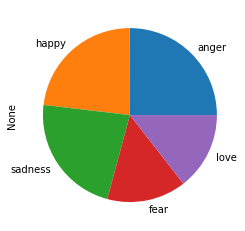

In [66]:
train_df.value_counts('label').plot(kind='pie')

In [67]:
# Sample data
labels = train_df.label.values

# Mapping function
def group_label(label):
    if label in ['happy']:
        return 'positive'
    elif label in ['anger', 'fear', 'sadness']:
        return 'negative'
    else:
        return 'neutral'

# Applying the mapping function to the labels
grouped_labels = [group_label(label) for label in labels]

# apply the grouped labels to the 
train_df['label'] = grouped_labels

In [68]:
X_train = train_df.tweet
y_train = train_df.label
X_test = test_df.tweet
y_test = test_df.label

<AxesSubplot:ylabel='None'>

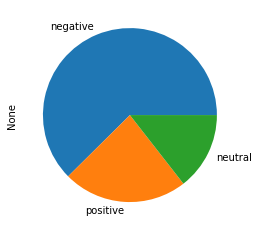

In [69]:
train_df.value_counts('label').plot(kind='pie')

## Data Preprocessing

In [70]:
print(X_train)
print(X_test)

0       Ini adalah hal yang paling membahagiakan saat ...
1       [USERNAME] [USERNAME] Dari pertama [USERNAME] ...
2       yaudah kalo emang belum berani potong rambut p...
3       Jadi semalam, gw rekap, eh intinya yg gw usaha...
4       temen2 masa kecil yang turned out being asshol...
                              ...                        
3516    [USERNAME] [USERNAME] Bcs doi w anak pelayaran...
3517    Sekali , dua kali , tiga kali , lama2 bosan ju...
3518    [USERNAME] [USERNAME] [USERNAME] [USERNAME] [U...
3519    Aku takut tulisan ini terbaca di saat kamu ngg...
3520     alhamdulilah tmksh tiara u to cantik dart ava oy
Name: tweet, Length: 3521, dtype: object
0     masih banyak org lain yg berjuang dan nilainya...
1             ambil UIN aja kalo mau tanpa uang pangkal
2     Lah u masuknya jalur apa, jurusan apa. Udh jls...
3     saya angkatan 97, dulu juga bisa dibilang saya...
4     u jealous right? mengutarakan keresahan akibat...
                            ...          

In [71]:
# Download the emoji library
demoji.download_codes()
lemmatizer = WordNetLemmatizer()
stopwords_en = set(stopwords.words('english'))
stopwords_id = set(stopwords.words('indonesian'))
stemmer = PorterStemmer()

def preprocess_tweet(tweet):
    tweet = demoji.replace_with_desc(tweet)
    tweet = tweet.lower()

    # Menghapus kata "username" "ugm_fess"
    tweet = re.sub(r'\busername\b', '', tweet)
    tweet = re.sub(r'\bugm_fess\b', '', tweet)
    
    tweet = lemmatizer.lemmatize(tweet)
    tweet = re.sub(r'\d+', '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = tweet.split()
    tweet = [word for word in tweet if word not in stopwords_en]
    tweet = [word for word in tweet if word not in stopwords_id]
    tweet = [stemmer.stem(word) for word in tweet]
    return tweet

# # Preprocess the tweets
# train_x = [preprocess_tweet(tweet) for tweet in X_train]
# test_x = [preprocess_tweet(tweet) for tweet in X_test]

<ipython-input-71-2dec7c096f0c>:2: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [72]:
# Preprocess the tweets
train_x = [preprocess_tweet(tweet) for tweet in X_train]
test_x = [preprocess_tweet(tweet) for tweet in X_test]

In [73]:
print(X_train)
print(train_x)

0       Ini adalah hal yang paling membahagiakan saat ...
1       [USERNAME] [USERNAME] Dari pertama [USERNAME] ...
2       yaudah kalo emang belum berani potong rambut p...
3       Jadi semalam, gw rekap, eh intinya yg gw usaha...
4       temen2 masa kecil yang turned out being asshol...
                              ...                        
3516    [USERNAME] [USERNAME] Bcs doi w anak pelayaran...
3517    Sekali , dua kali , tiga kali , lama2 bosan ju...
3518    [USERNAME] [USERNAME] [USERNAME] [USERNAME] [U...
3519    Aku takut tulisan ini terbaca di saat kamu ngg...
3520     alhamdulilah tmksh tiara u to cantik dart ava oy
Name: tweet, Length: 3521, dtype: object
[['membahagiakan', 'biasku', 'foto', 'elf', 'returnofthelittleprinc', 'happyheechulday'], ['menduduki', 'bangku', 'jabatan', 'rakyat', 'mendengar', 'hasil', 'kerja', 'prestasi', 'nyata', 'menduduki', 'bangku', 'jabatancoba', 'abdi', 'rakyat', 'butuh', 'seoran'], ['yaudah', 'kalo', 'emang', 'berani', 'potong', 'rambut', 

In [74]:
print(X_test)
print(test_x)

0     masih banyak org lain yg berjuang dan nilainya...
1             ambil UIN aja kalo mau tanpa uang pangkal
2     Lah u masuknya jalur apa, jurusan apa. Udh jls...
3     saya angkatan 97, dulu juga bisa dibilang saya...
4     u jealous right? mengutarakan keresahan akibat...
                            ...                        
74    Namun dengan adanya wacana penerapan uang pang...
75    Kita tahu, biaya kuliah semakin mahal apalagi ...
76    Bu Rektor tu kenapa ya? Urgensi beliau berlaku...
77    ugm_fess UGM gausah FOMO ngadain uang pangkal....
78    ugm adalah kampus kerakyatan meanwhile ugm jug...
Name: tweet, Length: 79, dtype: object
[['org', 'yg', 'berjuang', 'nilainya', 'sanggup', 'bayar', 'uang', 'pangkal', 'gk', 'sanggup', 'minggir', 'mbak', 'kaum', 'anti', 'sambat', 'gk', 'uang', 'utang', 'sik'], ['ambil', 'uin', 'aja', 'kalo', 'uang', 'pangkal'], ['u', 'masuknya', 'jalur', 'jurusan', 'udh', 'jl', 'jg', 'kampusnya', 'elit', 'knp', 'masuk', 'situ'], ['angkatan', 'dibil

# Feature Extraction

Dengan menggunakan model naive bayes, dicoba 2 fitur ekstrasi yaitu tf-idf dan count vector untuk dilihat mana fitur ekstraksi yang menghasilkan performance terbaik

In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Feature extraction options
vectorizers = [
    TfidfVectorizer(),
    CountVectorizer(),
]

for vectorizer in vectorizers:
    # Transform the data using the current vectorizer
    X_train_features = vectorizer.fit_transform(X_train)
    X_test_features = vectorizer.transform(X_test)

    # Initialize the Naive Bayes classifier
    nb_classifier = MultinomialNB()

    # Train the classifier
    nb_classifier.fit(X_train_features, y_train)

    # Make predictions on the test set
    y_pred = nb_classifier.predict(X_test_features)

    # Evaluate the classifier on the test set
    print("Vectorizer: ", type(vectorizer).__name__)
    print("Test Set Performance:")
    print(classification_report(y_test, y_pred))
    print("----------------------------------------")


Vectorizer:  TfidfVectorizer
Test Set Performance:
              precision    recall  f1-score   support

    negative       0.78      1.00      0.88        62
     neutral       0.00      0.00      0.00         6
    positive       0.00      0.00      0.00        11

    accuracy                           0.78        79
   macro avg       0.26      0.33      0.29        79
weighted avg       0.62      0.78      0.69        79

----------------------------------------


c:\Users\ASUS\AppData\Local\Programs\PythonCodingPack\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\PythonCodingPack\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\PythonCodingPack\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Vectorizer:  CountVectorizer
Test Set Performance:
              precision    recall  f1-score   support

    negative       0.80      0.97      0.88        62
     neutral       0.00      0.00      0.00         6
    positive       0.33      0.09      0.14        11

    accuracy                           0.77        79
   macro avg       0.38      0.35      0.34        79
weighted avg       0.67      0.77      0.71        79

----------------------------------------


Didapat hasil bahwa count vector mendapatkan nilai yang lebih baik dibanding tf-idf sehingga selanjutnya digunakanlah count vector sebagai fitur ekstraksinya

In [76]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = CountVectorizer()
# vectorizer = TfidfVectorizer()

X_train_str = [' '.join(tweet) for tweet in train_x]
X_test_str = [' '.join(tweet) for tweet in test_x]

X_train_features = vectorizer.fit_transform(X_train_str)
X_test_features = vectorizer.transform(X_test_str)

In [77]:
X_train_features

<3521x16045 sparse matrix of type '<class 'numpy.int64'>'
	with 56531 stored elements in Compressed Sparse Row format>

In [78]:
from sklearn.naive_bayes import MultinomialNB

# Initialize the Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the classifier
nb_classifier.fit(X_train_features, y_train)

# Make predictions on the test set
y_pred = nb_classifier.predict(X_test_features)

# Evaluate the classifier on the test set
print("Test Set Performance:")
print(classification_report(y_test, y_pred))

Test Set Performance:
              precision    recall  f1-score   support

    negative       0.80      0.95      0.87        62
     neutral       0.00      0.00      0.00         6
    positive       0.40      0.18      0.25        11

    accuracy                           0.77        79
   macro avg       0.40      0.38      0.37        79
weighted avg       0.68      0.77      0.72        79



c:\Users\ASUS\AppData\Local\Programs\PythonCodingPack\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\PythonCodingPack\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ASUS\AppData\Local\Programs\PythonCodingPack\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

<AxesSubplot:ylabel='None'>

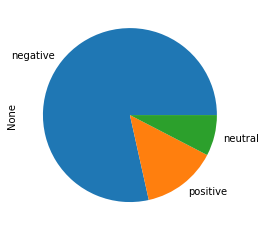

In [79]:
test_df.value_counts('label').plot(kind='pie')

# Confusion Matrix

[Text(0, 0.5, 'positive'), Text(0, 1.5, 'negative'), Text(0, 2.5, 'neutral')]

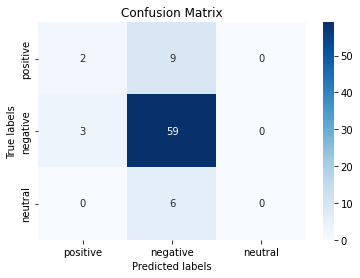

In [80]:
# visualize the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred, labels=['positive', 'negative', 'neutral'])
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['positive', 'negative', 'neutral'])
ax.yaxis.set_ticklabels(['positive', 'negative', 'neutral'])

Sumbu x mewakili label prediksi oleh model, sedangkan sumbu y mewakili label sebenarnya dari data pengujian. Setiap sel dalam matriks kebingungan menunjukkan jumlah sampel yang diprediksi dengan benar atau salah untuk setiap kombinasi label. Angka di dalam setiap sel menunjukkan jumlah sampel yang termasuk dalam kategori tersebut.
